# Keep it simple s...

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from collections import Counter
from modules.negative_set import generate_negative_set, get_box_parameters
from modules import data, models, descriptor_vector, validation, selection
from modules.selection import try_classifiers, try_params
from modules.window import compute_no_windows
import numpy as np
from skimage.transform import resize
from skimage.color import rgb2gray
import pickle
from pprint import pprint as pp

In [2]:
# Store
store = []

In [3]:
# Load data directly
GRAY = True
OFFSET = 0
LIMIT = None

full_images = images = data.load_images(limit=LIMIT, offset=OFFSET, gray=GRAY)
full_labels = labels = data.load_labels(limit=LIMIT, offset=OFFSET)
print(f"Using {len(images)}/1000 images & {len(labels)}/1284 labels")

In [28]:
# Limit if needed
LIMIT = 200
if LIMIT:
   images = full_images[OFFSET:OFFSET+LIMIT]
   labels = full_labels[full_labels[:,0] <= OFFSET+LIMIT]
   labels = labels[labels[:,0] > OFFSET]
else:
   images = full_images
   labels = full_labels
#if GRAY:
#    images = np.array([ rgb2gray(img) for img in images ])

## Params

In [38]:
# Global params
only_one_training = False
limit_score = 0.5
slide_step = (60,50)
downscale_step = 30
box_size = (150, 90)

# Model
CLASSIFIER = 'random_forest'
MODEL_PARAMS = {
    'n_estimators': 100,
#    'max_depth': None,
#    'max_features': 100,
    'class_weight': { -1: 1, 1: 1}
}
VECTORIZATION_PARAMS = {
    'vectorize': descriptor_vector.daisy,
#    'vectorize_kwargs': [6],
} 

## Adapt data

In [32]:
# Label sets
NEG_SIZE = 600
TRAIN_RATE = 0.75

print(f"Using {len(images)}/1000 images & {len(labels)}/1284 labels")
print(f"Generating {NEG_SIZE} negatives...")
negatives = generate_negative_set(images, labels, set_size=NEG_SIZE)

print("Creating train & validation sets with negatives...")
all_labels = np.concatenate([labels, negatives])
train_labels, valid_labels = label_sets = data.train_valid_sets(len(images), all_labels, TRAIN_RATE)
print(f"Train: {len(np.unique(train_labels[:,0]))}, Valid: {len(np.unique(valid_labels[:,0]))}")
print(Counter(train_labels[:,5]), Counter(valid_labels[:,5]))

Using 200/1000 images & 266/1284 labels
Generating 600 negatives...
Creating train & validation sets with negatives...
Train: 150, Valid: 50
Counter({-1: 443, 1: 210}) Counter({-1: 157, 1: 56})


## Try

### 1. Main Single

In [53]:
# ( 1 ) --- Single --- Train, predict, validate
clf = models.create_model(CLASSIFIER, MODEL_PARAMS)
kwargs = { 'limit_score': limit_score, 'slide_step': slide_step, 'downscale_step': downscale_step }

print("Training...")
train_results = models.train(clf, images, box_size, train_labels, **VECTORIZATION_PARAMS,
                             only_one_training=only_one_training, **kwargs)

Training...
Vectorizing data...
First training with 653 rows...



Adding 86 false positives / 202 predictions
Vectorizing data...
Second training with 739 rows...


In [39]:
print("Predicting with windows...")
valid_indexes = np.unique(valid_labels[:,0]) - 1
predictions, scores = models.predict(clf, images, box_size, **VECTORIZATION_PARAMS,
                                     only=valid_indexes, with_scores=True,**kwargs)

results = validation.rate_predictions(predictions, valid_labels)
print("Done")

print("\n------\n")
if results not in store: store.append(results)
pp(results)

Predict with additional negatives...
{'avg_precision': 0.8337286944298015,
 'f1-score': 0.9019607843137255,
 'precision': array([0.06888069, 1.        , 1.        ]),
 'recall': array([1.        , 0.82142857, 0.        ]),
 'roc_auc_score': 0.9107142857142857}


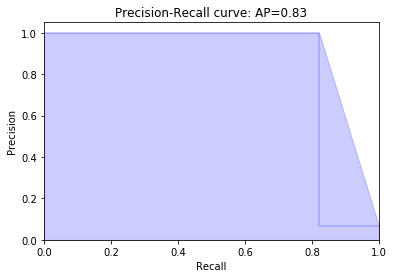

In [54]:
NEG_SUP = 4000
pvalid_labels = np.concatenate([ valid_labels, generate_negative_set(images, labels, set_size=NEG_SIZE) ])
pvalid_indexes = np.unique(valid_labels[:,0]) - 1

print("Predict with additional negatives...")
scores, results = models.predict_and_validate(clf, images, box_size, pvalid_labels,
                                              **VECTORIZATION_PARAMS, only=pvalid_indexes,**kwargs)
pp(results)

-----
-----
-----

{'avg_precision': 0.8420523138832998, 'precision': array([0.2629108, 1.       , 1.       ]), 'recall': array([1.        , 0.78571429, 0.        ]), 'f1-score': 0.88, 'roc_auc_score': 0.8928571428571428}


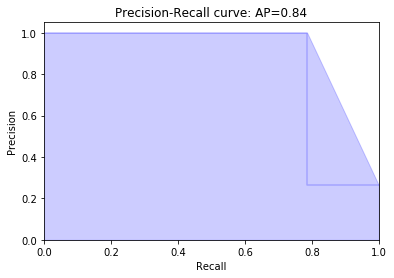

In [49]:
scores, results = models.predict_and_validate(clf, images, box_size, valid_labels,
                                              **VECTORIZATION_PARAMS, only=valid_indexes,**kwargs)
print(results)

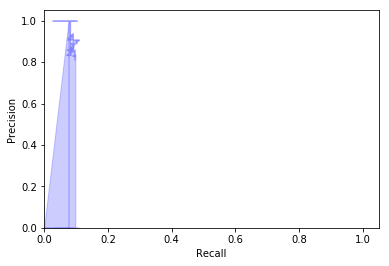

In [45]:
from modules.validation import pr_curve
%matplotlib inline
pr_curve(labels, predictions)

In [8]:
# ( 4 ) --- Haar features optimized
int_images = descriptor_vector.compute_integral_images(images)


In [25]:
from skimage.feature import haar_like_feature, haar_like_feature_coord
slide_step = (10, 10)
box_size = (30, 30)
feature_type = 'type-3-x'

iimg = int_images[0]
h, l = iimg.shape[:2]

ft_coord, ft_type = haar_like_feature_coord(*box_size[::-1], feature_type=feature_type)
ft_rate = 0.7
n_features = int(ft_coord.shape[0] * ft_rate)

print(compute_no_windows(iimg, box_size, slide_step, downscale_step))
print(ft_coord.shape[0])

8743
67280


In [20]:
def compute_haar(iimg, ft_set, box_size, slide_step, downscale_step):
    assert all([ len(x) == 2 for x in (ft_set, slide_step, box_size)])
    ft_coord, ft_type = ft_set
    slide_h, slide_l = slide_step
    box_h, box_l = box_size
    
    n_windows = compute_no_windows(iimg, box_size, slide_step, downscale_step)
    n_features = ft_coord.shape[0]

    features = np.empty((, n_features))
    for x in range(0, h - box_h, slide_h):
        for y in range(0, l - box_l, slide_l):
            ft = haar_like_feature(iimg, x, y, *box_size[::-1], feature_type=ft_type, feature_coord=ft_coord)
            r.append(ft)
        break

    return features

(42, 67280)
[[-4.76427451e-01 -9.58526275e-01 -1.40833608e+00 ... -1.14430980e-01
  -1.02941176e-01 -1.04347843e-01]
 [-5.26036745e+00 -5.65385373e+00 -5.88058431e+00 ... -9.26435294e-02
  -9.65650980e-02 -9.26435294e-02]
 [-8.54944745e+00 -8.72380314e+00 -8.85191059e+00 ... -9.65650980e-02
  -9.34541176e-02 -9.65650980e-02]
 ...
 [-1.46704142e+02 -1.47185064e+02 -1.47689516e+02 ... -5.48482745e-01
  -5.41747843e-01 -5.37826275e-01]
 [-1.51608354e+02 -1.52125441e+02 -1.52634685e+02 ... -5.26061569e-01
  -5.26061569e-01 -5.26061569e-01]
 [-1.56751777e+02 -1.57288473e+02 -1.57823592e+02 ... -5.17087451e-01
  -5.17087451e-01 -5.17087451e-01]]


In [34]:
# ( 1bis ) --- Single --- Train, predict, validate
clf = models.create_model(CLASSIFIER, MODEL_PARAMS)
kwargs = { 'limit_score': limit_score, 'slide_step': slide_step, 'downscale_step': downscale_step }

print("Training...")
train_results = models.train(clf, images, box_size, train_labels, **VECTORIZATION_PARAMS,
                             only_one_training=only_one_training, **kwargs)

Training...
First training...


Predicting windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  2.21it/s]


Adding 10 false positives / 61 predictions
Second training...


In [ ]:
coordinates, windows = sliding_windows(img, box_size, slide_step, downscale_step)
print(coordinates.shape)
print(windows.shape)
print(descriptor_vector.hog(windows).shape)

In [167]:
img = images[49]
h, l = img.shape[:2]
r = h / l
s = downscale_step
box_h, box_l = box_size
gen = list(downscale_image(img, step=downscale_step, min_height=box_h, min_width=box_l))

n_scaled_img = 1 + int(min(
    ((h - box_h) / downscale_step),
    ((l - box_l) / (downscale_step/r)),
))

print(
    ((h - box_h) / downscale_step),
    ((l - box_l) / (downscale_step/r)),
)

print(n_scaled_img, len(gen), n_scaled_img == len(gen))
print("b", box_size, "s", downscale_step)
for i in gen:
    print(i.shape[:2])

10.0 10.99406528189911
11 10 False
b (150, 90) s 30
(450, 337)
(420, 314)
(390, 292)
(360, 269)
(330, 247)
(300, 224)
(270, 202)
(240, 179)
(210, 157)
(180, 134)


In [189]:
from modules.window import compute_no_windows
from random import randrange
i = randrange(len(full_images))
img = full_images[i]

n1 = compute_no_windows(img, box_size, slide_step, downscale_step)
n2 = sliding_windows(img, box_size, slide_step, downscale_step)
print(n1, n2, n1 == n2)

(5, 6)
(5, 5)
(4, 5)
(4, 4)
(3, 4)
(3, 3)
(2, 3)
(2, 2)
(1, 2)
(1, 2)
10
9
126 126 True


In [ ]:
from skimage.io import imshow_collection
imgs = []
for falpos in train_results:
    img_id = falpos[0]
    x,y,h,l = falpos[1:5]
    img = images[img_id-1]
    imgs.append(img[x:x+h,y:y+l])
imshow_collection(imgs)

In [73]:
# ( 2 ) --- Multiple --- Try multiple params
clf_name = 'random_forest'
global_params = {
    # General
    'box_size': (150, 90),

    'n_estimators': 50,
    'class_weight': { -1: 1, 1: 1},

    'vectorization_params': {
        'vectorize': descriptor_vector.hog,
#        'vectorize_kwargs': { 'orientations': 6},
    },
}

kwargs = {
    'limit_score': 0.5,
    'slide_step': (60,50),
    'downscale_step': 30,
    'only_one_training': True,
}

changing_params = {
    'vectorization_params': [
#        { 'vectorize': descriptor_vector.haar, },
        { 'vectorize': descriptor_vector.hog, },
        { 'vectorize': descriptor_vector.daisy, },
    ]
}

results = try_params(images, label_sets, clf_name, global_params, changing_params, **kwargs)
print("\n------\n")
if results not in store: store.append(results)
pp(results)

## Trying parameter `vectorization_params`...
### with value `{'vectorize': <function haar at 0x000001370D3FAD90>}`
Vectorizing data...


ValueError: not enough values to unpack (expected 2, got 0)